In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
# Split the training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [4]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_val.shape)
print('Validation Labels Shape: ', y_val.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (40000, 32, 32, 3)
Train Labels Shape:       (40000, 1)

Validation Images Shape:  (10000, 32, 32, 3)
Validation Labels Shape:  (10000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


In [5]:
# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (40000, 32, 32, 3)
X_val shape: (10000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)


In [6]:
# Transform target variable into one-hotencoding
y_category_train = to_categorical(y_train, 10)
y_category_val = to_categorical(y_val, 10)
y_category_test = to_categorical(y_test, 10)

In [7]:
data_generator = ImageDataGenerator(
    width_shift_range=0.1,

    rotation_range=10,

    # zoom_range=0.1,

    # brightness_range=[0.9,1.1],

    # shear_range=10,

    # channel_shift_range=0.1,

    height_shift_range=0.1, 

    horizontal_flip=True    
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [8]:
from keras.applications import ResNet50
from keras.layers import Dense
from keras.models import Sequential

batch_size = 32
train_generator = data_generator.flow(X_train, y_category_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

model_pretrain = Sequential()
base_model = ResNet50(input_shape=(32, 32, 3), include_top=False, weights='imagenet', pooling='avg')
model_pretrain.add(base_model)
model_pretrain.add(Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

model_pretrain.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Eval = model_pretrain.fit(train_generator, 
              epochs=10,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_val, y_category_val), 
              callbacks=[early_stop],
             )

Epoch 1/10
1250/1250 [==============================] - 1115s 876ms/step - loss: 2.8057 - accuracy: 0.1776 - val_loss: 2.0671 - val_accuracy: 0.2291
Epoch 2/10
1250/1250 [==============================] - 986s 789ms/step - loss: 1.8160 - accuracy: 0.3128 - val_loss: 2.4355 - val_accuracy: 0.2888
Epoch 3/10
1250/1250 [==============================] - 992s 793ms/step - loss: 1.5869 - accuracy: 0.4179 - val_loss: 2.2308 - val_accuracy: 0.3236
Epoch 4/10
1250/1250 [==============================] - 995s 796ms/step - loss: 1.4447 - accuracy: 0.4757 - val_loss: 1.8874 - val_accuracy: 0.3857
Epoch 5/10
1250/1250 [==============================] - 984s 787ms/step - loss: 1.3216 - accuracy: 0.5322 - val_loss: 1.4731 - val_accuracy: 0.4765
Epoch 6/10
1250/1250 [==============================] - 984s 787ms/step - loss: 1.2285 - accuracy: 0.5645 - val_loss: 1.7152 - val_accuracy: 0.4688
Epoch 7/10
1250/1250 [==============================] - 983s 787ms/step - loss: 1.1296 - accuracy: 0.6036 - val

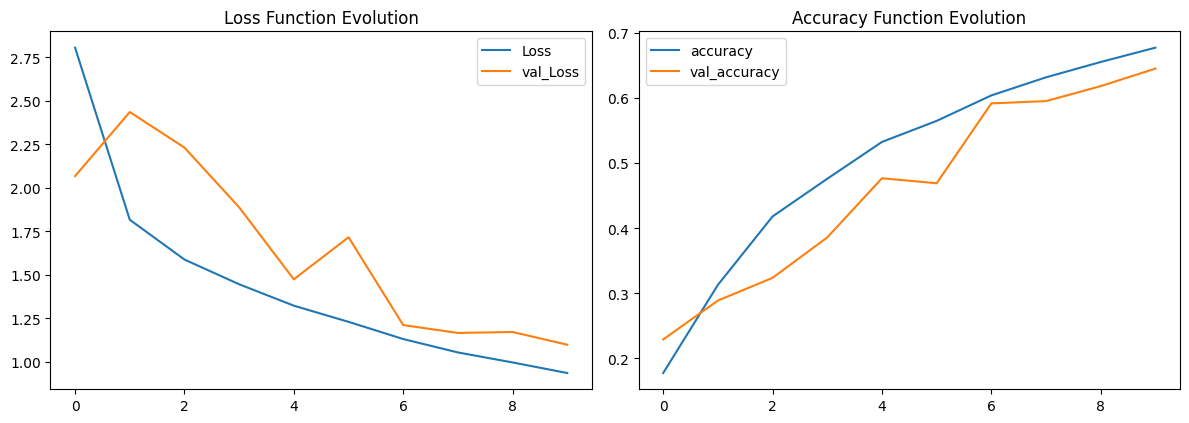

In [10]:
# Plotting
plt.figure(figsize=(12, 16))

# Loss plot
plt.subplot(4, 2, 1)
plt.plot(Eval.history['loss'], label='Loss')
plt.plot(Eval.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

# Accuracy plot
plt.subplot(4, 2, 2)
plt.plot(Eval.history['accuracy'], label='accuracy')
plt.plot(Eval.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 19s 62ms/step - loss: 1.1270 - accuracy: 0.6393
Test Accuracy : 63.93%
313/313 [==============================] - 18s 58ms/step


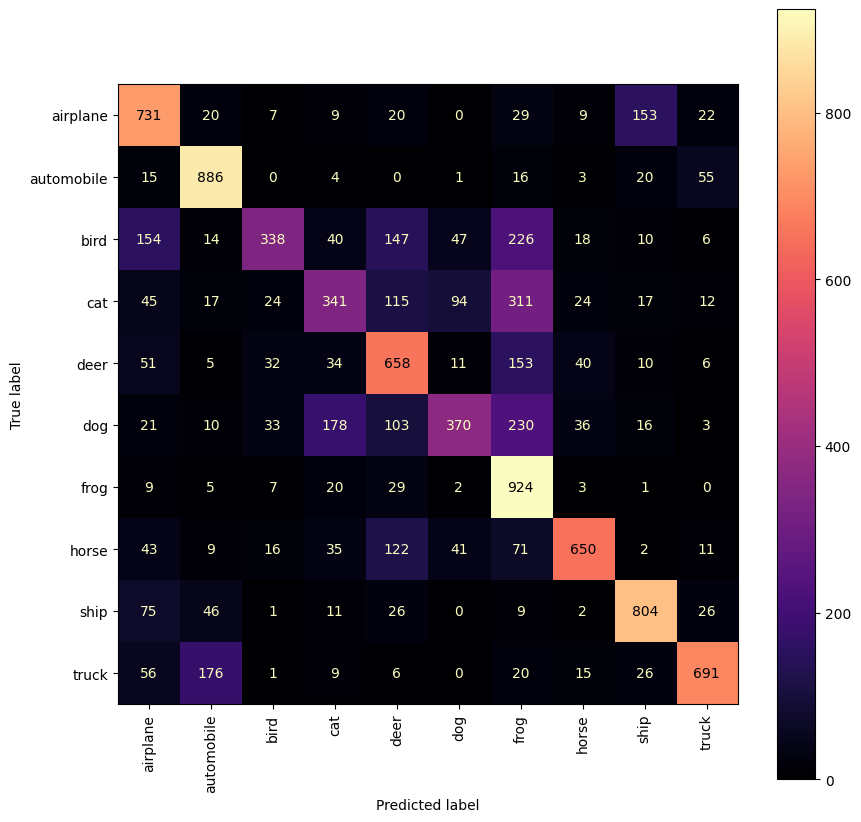

In [12]:
# CIFAR-10 classes
lables = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
evaluation = model_pretrain.evaluate(X_test, y_category_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model_pretrain.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lables)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='magma')

plt.show()

### Hyperparameter Tuning: Experiment with optimizers, learning rates, and model depth to improve performance. Document your findings in comments

- Model 1 Accuracy: 72.50%
- Model 2 Accuracy: 82.07%

1. Model Depth
- Model 1 (2 convolutional layers):
  The shallow model exhibits slower performance improvement compared to the deeper model. While it achieves improvements in accuracy, precision, recall, and F1-score over the epochs, the learning progress is gradual.
  The validation metrics for the shallow model show fluctuations, especially in the early epochs. This indicates possible underfitting due to the limited capacity of the model.
  The shallow structure appears to stabilize but plateaus earlier

- Model 2 (3 convolutional blocks):
  The deeper model outperforms the shallow model in all metrics (accuracy, precision, recall, F1-score), as evidenced by the smoother and faster convergence.
  The additional layers improve feature extraction, leading to higher validation performance.
  Validation stability is significantly better for the deeper model, with fewer erratic fluctuations. This indicates a better generalization ability compared to Model 1.

2. Learning Rate

- Model 1 (Learning rate = 0.05):
  A learning rate of 0.05 is relatively high and causes notable oscillations in validation loss and metrics early in training.
  The high learning rate result in the model overshooting optimal minima, leading to instability. While it eventually stabilizes, the overall performance lags behind the deeper model with a lower learning rate.

- Model 2 (Learning rate = 0.005):
  A lower learning rate of 0.005 results in smoother convergence and better optimization, as evidenced by the consistent improvement in training and validation metrics.
  The lower learning rate allows for finer adjustments to weights during training.

3. Optimizer

- Model 1 (Optimizer: SGD):
  SGD (Stochastic Gradient Descent) is less effective in this case, especially with the high learning rate.
  While SGD works well for simpler problems, it struggles with convergence speed and stability in this case, given the complexity of the data and architecture.

- Model 2 (Optimizer: Adam):
  Adam optimizer proves more effective for the deeper model, achieving faster convergence and better performance across all metrics.
  Adam’s adaptive learning rate adjustment likely helps balance the optimization process, particularly for deeper architectures with more parameters.